Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
72000
18000
Epoch 1/30
282/282 [==============================] - 292s 1s/step - loss: 2.4142 - accuracy: 0.3036 - val_loss: 3.4719 - val_accuracy: 0.1541
Epoch 2/30
282/282 [==============================] - 287s 1s/step - loss: 1.8035 - accuracy: 0.4813 - val_loss: 3.1875 - val_accuracy: 0.4686
Epoch 3/30
282/282 [==============================] - 288s 1s/step - loss: 1.4597 - accuracy: 0.5872 - val_loss: 2.6056 - val_accuracy: 0.6052
Epoch 4/30
282/282 [==============================] - 288s 1s/step - loss: 1.2204 - accuracy: 0.6558 - val_loss: 2.0772 - val_accuracy: 0.6791
Epoch 5/30
282/282 [==============================] - 287s 1s/step - loss: 1.0353 - accuracy: 0.7112 - val_loss: 1.8536 - val_accuracy: 0.7077
Epoch 6/30
282/282 [==============================] - 288s 1s/step - loss: 0.9081 - accuracy: 0.7456 - val_loss: 1.6666 - val_accuracy: 0.7389

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/ProteinReader/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/ProteinReader/assets


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 49, 64)            22016     
_________________________________________________________________
batch_normalization_3 (Batch (None, 49, 64)            256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 49, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 49, 128)           98816     
_________________________________________________________________
batch_normalization_4 (Batch (None, 49, 128)           512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 49, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 216)              

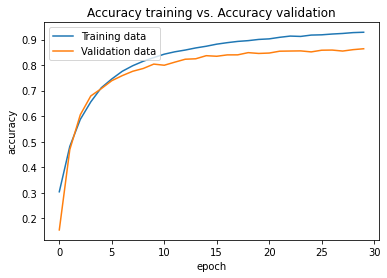

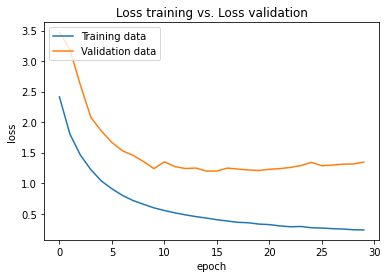

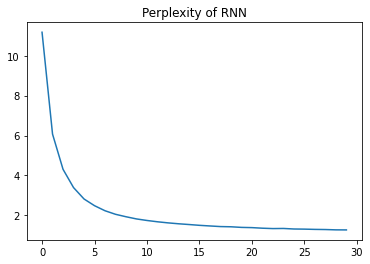

In [2]:
# Here we import the modules that we will use for the task
import numpy as np
import math
import statistics
import tensorflow as tf
import string
import random
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive
from tensorflow.python.framework import ops
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing


# We mount our Google Drive that contains the datasets
drive.mount('/content/gdrive')




### The function for gathering tests
def read_seqV2(sequence):
    f = open(sequence, 'r')
    test = []
    testlabel = []

    # Reading file and extracting paths and labels
    with open(sequence, 'r') as File:
      infoFile = File.readlines() # Reading all the lines from File
      count = 0
      
      for line in infoFile: #Reading line-by-line
        # get testing data
        if count == 90000:
          return test, testlabel

        if count % 5 == 0: # else, put it in a the training set, also known as x_train, and training label set, also known as y_train.
          temp = line.split()
          charList = list(temp[0])
          seq = []
          
          # if for some reason the protein sequence is less than 50 char long
          if len(charList) < 50:
            for i in range(len(charList)):
              seq.append(ord(charList[i]) - ord('A') + 1)
            
            if seq[len(seq)-1] > 20:
               seq[len(seq)-1] = 20

            label = seq[len(seq)-1]
            
            while len(seq) < 50:
              seq.append(0)
            
            # grab the labels and convert seq into a one hot encoding of 21
            seq = tf.one_hot(seq,21)
            test.append(seq[:len(seq)-1])
            testlabel.append(label)
            seq = []

          else:
            for i in range(50): # convert each letter into an int
              seq.append(ord(charList[i]) - ord('A') + 1)
            
            # grab the labels and convert seq into a one hot encoding of 21
            if seq[len(seq)-1] > 20:
               seq[len(seq)-1] = 20

            label = seq[len(seq)-1]
            seq = tf.one_hot(seq,21)
            test.append(seq[:len(seq)-1])
            testlabel.append(label)
            seq = []

        count += 1
        
      #return test, testlabel




#### The function for reading and parsing file
def read_seq(sequence):
    f = open(sequence, 'r')
    train = []
    trainlabel = []

    # Reading file and extracting paths and labels
    with open(sequence, 'r') as File:
      infoFile = File.readlines() # Reading all the lines from File
      count = 0
      
      for line in infoFile: #Reading line-by-line
        if count == 90000:
          return train, trainlabel

        # training data addin
        if count % 5 != 0: # training data found
          temp = line.split()
          charList = list(temp[0])
          seq = []
          
          # if for some reason the protein sequence is less than 50 char long
          if len(charList) < 50:
            for i in range(len(charList)):
              seq.append(ord(charList[i]) - ord('A') + 1)
            
            while len(seq) < 50:
              seq.append(0)
            
            # grab the labels and convert seq into a one hot encoding of 21
            if seq[len(seq)-1] > 20:
               seq[len(seq)-1] = 20

            label = seq[len(seq)-1]
            seq = tf.one_hot(seq,21)
            train.append(seq[:len(seq)-1])
            trainlabel.append(label)
            seq = []

          else:
            for i in range(50): # convert each letter into an int
              seq.append(ord(charList[i]) - ord('A') + 1)
            
            # grab the labels and convert seq into a one hot encoding of 21
            if seq[len(seq)-1] > 20:
               seq[len(seq)-1] = 20

            label = seq[len(seq)-1]
            seq = tf.one_hot(seq,21)
            train.append(seq[:len(seq)-1])
            trainlabel.append(label)
            seq = []

        count += 1



# We parse files to get training data
seq_train, train_label = read_seq('/content/gdrive/My Drive/pdb_seqres.txt')
seq_test, test_label = read_seqV2('/content/gdrive/My Drive/pdb_seqres.txt')

print(len(seq_train))
print(len(seq_test))

# We reshape labels to be 2d arrays
train_label = np.asarray(train_label).astype('float32').reshape((-1,1))
test_label = np.asarray(test_label).astype('float32').reshape((-1,1))

# We convert labels (y_train and y_test) to tensors
train_label = ops.convert_to_tensor(train_label, dtype=tf.float32)
test_label = ops.convert_to_tensor(test_label, dtype=tf.float32)

# We make the training and testing tensors floats instead of ints
seq_train = ops.convert_to_tensor(seq_train, dtype=tf.float32)
seq_test = ops.convert_to_tensor(seq_test, dtype=tf.float32)

# We create out recurrent neural network (RNN) 
# low dropout == better accuracy
model = keras.Sequential(
    [
     layers.LSTM(64, return_sequences=True, activation='relu'), # LSTM layer
     layers.BatchNormalization(), 
     layers.Dropout(0.1),
     layers.LSTM(128, return_sequences=True, kernel_initializer='glorot_uniform', activation='tanh', bias_initializer='zeros'), # This is the LSTM layer with weights initialized
     layers.BatchNormalization(),
     layers.Dropout(0.2),
     layers.LSTM(216, return_sequences=False, activation='tanh'), # LSTM layer
     layers.BatchNormalization(), 
     layers.Dropout(0.3),
     layers.Dense(21, activation='softmax') # Output layer
    ]
)

"""
For extra credit portion - testing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=1000,
    decay_rate=0.9)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

Optimizer.apply_gradients(
    grads_and_vars, name=None, experimental_aggregate_gradients=True
)
"""

# We compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# We get the history of the model to plot stuff
historyMod = model.fit(x=seq_train, y=train_label, shuffle=True, epochs=30, batch_size=256, validation_data=(seq_test, test_label))


# save the model
model.save('/content/gdrive/My Drive/ProteinReader')

# We print out a summary of our model
model.summary()

# We plot results of the training model
plt.plot(historyMod.history['accuracy'], label='Training data')
plt.plot(historyMod.history['val_accuracy'], label='Validation data')
plt.title('Accuracy training vs. Accuracy validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc="upper left")
plt.show()

# We plot the loss
plt.plot(historyMod.history['loss'], label='Training data')
plt.plot(historyMod.history['val_loss'], label='Validation data')
plt.title('Loss training vs. Loss validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc="upper left")
plt.show()

# This portion takes care of the perplexity plotting
perplexity = tf.exp(historyMod.history['loss'])
plt.plot(perplexity)
plt.title('Perplexity of RNN')
plt.show()

